> Exploring the effect of k-decay on Cosine Schedules.

# Introduction

This notebook is Part 4 in a [series](https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-4/) on dynamic Classifier-free Guidance. It explores more advanced schedules for the guidance parameter $G$. 

## Recap of Parts 1-3  

The first three parts explored how to turn Classifier-free Guidance into a dynamic process. We found an initial set of schedules and normalizers that seem to improve the quality of Diffusion images.  

## Part 4: Alternative warmups for cosine schedules

Part 4 is an exploration of [kDecay](https://arxiv.org/pdf/2004.05909.pdf) applied to Cosine Schedules.  

The `kDecay` paper introduces a hyperparameter $k$ for scheduled learning rates. This parameter empirically improves the performance of models across many learning rate schedules.   

Here we explore two aspects of $k$ for the guidance parameter $G$:  

1. The effect of $(\ k\ <\ 1\ )$ and $(\ k\ >\ 1\ )$ on the guidance parameter.   
2. How an inverse `kDecay` schedule can be used as a type of warm up.  

# Python imports

We start with a few basic python imports.

In [ ]:
import os
import random
from functools import partial
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Seed for reproducibility

`seed_everything` makes sure that the results are reproducible across notebooks.

In [ ]:
# set the seed and pseudo random number generator
SEED = 1024
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    generator = torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return generator

# for sampling the initial, noisy latents
generator = seed_everything(SEED)

# Generating cosines with k-decay

We can easily create different $k$ values with the `cf_guidance` library.

In [ ]:
# helpers to create cosine schedules
from cf_guidance.schedules  import get_cos_sched

# normalizations for classifier-free guidance
from cf_guidance.transforms import GuidanceTfm, BaseNormGuidance

For the other schedule parameters, we will use the [same values](https://enzokro.dev/blog/posts/2022-11-20-guidance-expts-2/#default-schedule-parameters) from the running series.  

The rest of the functions below are also brought in from previous notebooks. They are used to create the different schedule values.

In [ ]:
# Default schedule parameters from the blog post
######################################
max_val           = 7.5   # guidance scaling value
min_val           = 1.    # minimum guidance scaling
num_steps         = 50    # number of diffusion steps
num_warmup_steps  = 0     # number of warmup steps
warmup_init_val   = 0     # the intial warmup value
num_cycles        = 0.5   # number of cosine cycles
k_decay           = 1     # k-decay for cosine curve scaling 

# smaller values for T-Norm and FullNorm
max_T = 0.15
min_T = 0.05
######################################

DEFAULT_COS_PARAMS = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_cycles':        num_cycles,
    'k_decay':           k_decay,
    'num_warmup_steps':  num_warmup_steps,
    'warmup_init_val':   warmup_init_val,
}

def cos_harness(new_params={}, default_params={}):
    '''Creates cosine schedules with updated parameters in `new_params`
    '''
    # start from the given baseline `cos_params`
    cos_params = dict(default_params)
    # update the schedule with any new parameters
    cos_params.update(new_params)
    
    # return the new cosine schedule
    sched = get_cos_sched(**cos_params)
    return sched


def create_expts(params: dict, schedule_func) -> list:
    '''Creates a list of experiments.
    
    Each element is a dictionary with the name, value, and schedule for a given parameter.
    A `title` field is also added for easy plotting.
    '''
    names = sorted(params)
    expts = []
    # step through parameter names and their values
    for i,name in enumerate(names):
        for j,val in enumerate(params[name]):
            # create the experiment
            expt = {'param_name': name,
                    'val': val,
                    'schedule': schedule_func({name: val})}
            # name for plotting
            expt['title'] = f'Param: "{name}", val={val}'
            # add it to the experiment list
            expts.append(expt)
    return expts

Next we use the functions above to create the k-decay cosine values.

In [ ]:
# create the k-decay cosine experiments
cos_params = {'k_decay': [0.1, 0.2, 0.3, 0.5, 0.7, 1., 1.5, 2, 3, 5]}
cos_func = partial(cos_harness, default_params=DEFAULT_COS_PARAMS)
cos_expts = create_expts(cos_params, cos_func)

# Plotting the different $k$ values

Let's plot the sweep of $k$ values to see how they change the cosine schedule. For reference, the value of $k = 1$ is the default.

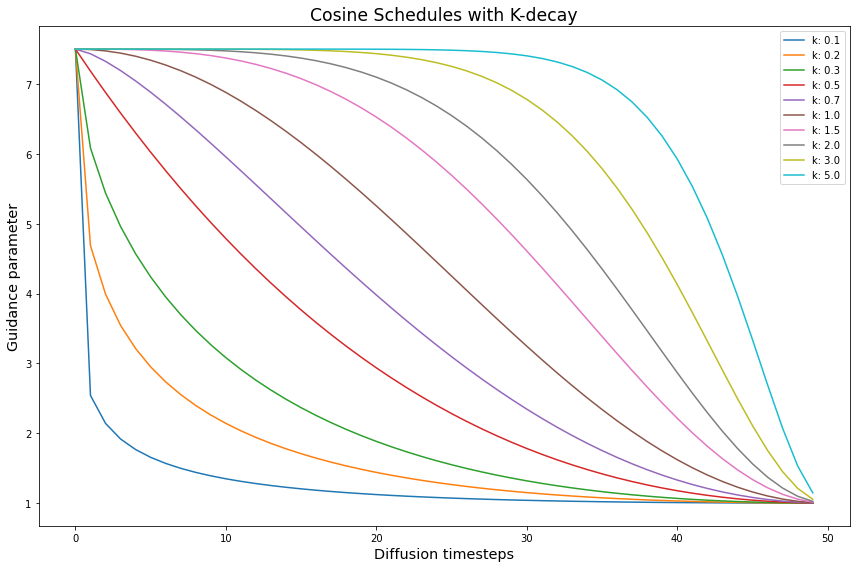

In [ ]:
#| echo: false
#| output: true
colors=list(mcolors.TABLEAU_COLORS)

# setup the plot
fig,ax = plt.subplots(figsize=(12,8))
plt.title('Cosine Schedules with K-decay', fontsize='xx-large')
plt.xlabel('Diffusion timesteps', fontsize='x-large')
plt.ylabel('Guidance parameter', fontsize='x-large')

# plot each k values
for idx,s in enumerate(cos_expts):
    ax.plot(s['schedule'], c=colors[idx], label=f'k: {s["val"]:.1f}')
    
plt.legend()
plt.tight_layout();

The curves to the left of the default $k = 1$ are "squished" by smaller $k$ values. While the curves to its right are expanded out.  

We see that $k$ affects how quickly the guidance parameter decreases. What does this decrease mean for Diffusion images?

Consider that at the start of a diffusion process, the image is pure, random noise. It makes sense to strongly guide the image toward the given input prompt, else the model will freely hallucinate and ignore the prompt. This is the main idea behind Classifier-free Guidance.  

What we are trying to find is a different, more gradual increase in $G$ that might improve the quality of generated images.  

# Inverting the `kDecay` schedules

An interesting thing happens when we "invert" the $k$ schedules. Here, inverting means that we mirror the schedule along it's y-axis midpoint.  

In [ ]:
# stores the inverted schedules
inv_cos_expts = []

# flip the schedules
for s in cos_expts:
    new_vals = dict(s)
    inv = [max_val - g + min_val for g in s['schedule']]
    new_vals['schedule'] = inv
    inv_cos_expts.append(new_vals)

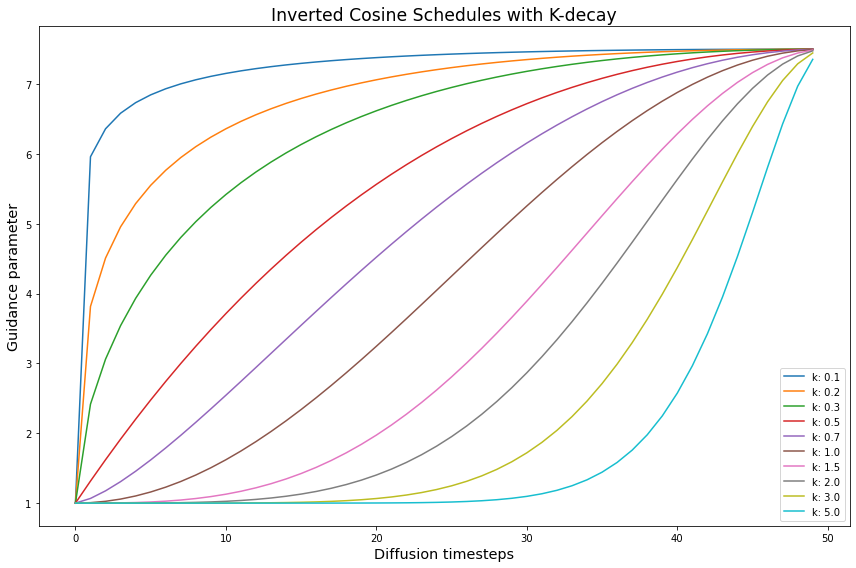

In [ ]:
#| echo: false
#| output: true

# plot the inverted schedules
fig,ax = plt.subplots(figsize=(12,8))
plt.title('Inverted Cosine Schedules with K-decay', fontsize='xx-large')
plt.xlabel('Diffusion timesteps', fontsize='x-large')
plt.ylabel('Guidance parameter', fontsize='x-large')

for idx,s in enumerate(inv_cos_expts):
    ax.plot(s['schedule'], c=colors[idx], label=f'k: {s["val"]:.1f}')
    
plt.legend()
plt.tight_layout();

Notice how, after inversion, the smallest $k$ values become steep warmups that quickly saturate toward the max. By contrast, the largest $k$ values now act like extremely slow warmups.

We expect that $k$ schedules that quickly reach a high guidance value will generate better images. Likewise, $k$ schedules that remain at higher guidance values for longer will do the same.  

The open question is whether the smooth, inverse k-decay is a better warmup than a simple linear increase. This question is inspired by the slower, more gradual diffusion variance schedules in recent efforts.  

With this full suite of `kDecay` schedules to explore, we are ready to generate some images. 

# Loading the `openjourney` model from Prompt Hero

The `min_diffusion` library loads a Stable Diffusion model from the HuggingFace hub.

In [ ]:
# to load Stable Diffusion pipelines
from min_diffusion.core import MinimalDiffusion

# to plot generated images
from min_diffusion.utils import show_image, image_grid, plot_grid

2022-11-24 17:24:16.457198: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


The following code loads the `openjourney` model on the GPU, with `torch.float16` precision.

In [ ]:
model_name = 'prompthero/openjourney'
device     = 'cuda'
dtype      = torch.float16

In [ ]:
pipeline = MinimalDiffusion(model_name, device, dtype, generator=generator)

In [ ]:
pipeline.load(unet_attn_slice=False);

# Text prompt for image generations

We use the familiar, running prompt in our series to generate an image:  

> "a photograph of an astronaut riding a horse"

:::: {.callout-important}  
The `openjourney` model was fine-tuned to create images in the style of [Midjourney v4](https://mezha.media/en/2022/11/11/midjourney-v4-is-an-incredible-new-version-of-the-ai-image-generator/).  

To enable this fine-tuned style, we need to add the keyword `"mdjrny-v4"` at the start of the prompt.  
::::

In [ ]:
# text prompt for image generations
prompt = "mdjrny-v4 style a photograph of an astronaut riding a horse"

## Image parameters

Images will be generated over $50$ diffusion steps. They will have a height and width of `512 x 512` pixels. 

In [ ]:
# the number of diffusion steps
num_steps = 50

# generated image dimensions
width, height = 512, 512

# Running the experiments

The `run` function below generates images for the given `prompt`.  

It also stores the output images with a matching title for plotting and visualizations.

In [ ]:
def run(prompt, schedules, guide_tfm=None, generator=None,
        show_each=False, test_run=False):
    """Runs a dynamic Classifier-free Guidance experiment. 
    
    Generates an image for the text `prompt` given all the values in `schedules`.
    Uses a Guidance Transformation class from the `cf_guidance` library.  
    Stores the output images with a matching title for plotting. 
    Optionally shows each image as its generated.
    If `test_run` is true, it runs a single schedule for testing. 
    """
    # store generated images and their title (the experiment name)
    images, titles = [], []
    
    # make sure we have a valid guidance transform
    assert guide_tfm
    print(f'Using Guidance Transform: {guide_tfm}')
    
    # optionally run a single test schedule
    if test_run:
        print(f'Running a single schedule for testing.')
        schedules = schedules[:1]
        
    # run all schedule experiments
    for i,s in enumerate(schedules):
        
        # parse out the title for the current run
        cur_title  = s['title']
        titles.append(cur_title)
        
        # create the guidance transformation 
        cur_sched = s['schedule']
        gtfm = guide_tfm({'g': cur_sched})
        
        print(f'Running experiment [{i+1} of {len(schedules)}]: {cur_title}...')
        img = pipeline.generate(prompt, gtfm, generator=generator)
        images.append(img)
        
        # optionally plot the image
        if show_each:
            show_image(img, scale=1)

    print('Done.')
    return {'images': images,
            'titles': titles}

## Setting the baseline with $G = 7.5$

First we create and display the baseline imagine using a constant Classifier-free Guidance with $G = 7.5$. Since this is a constant schedule, $k$ does not come into play.  

In [ ]:
# create the baseline schedule with the new function
baseline_g = 7.5
baseline_params = {'max_val': [baseline_g]}
baseline_func = lambda params: [baseline_g for _ in range(num_steps)]
baseline_expts = create_expts(baseline_params, baseline_func)

In [ ]:
baseline_res = run(prompt, baseline_expts, guide_tfm=GuidanceTfm)

Using Guidance Transform: <class 'cf_guidance.transforms.GuidanceTfm'>
Running experiment [1 of 1]: Param: "max_val", val=7.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


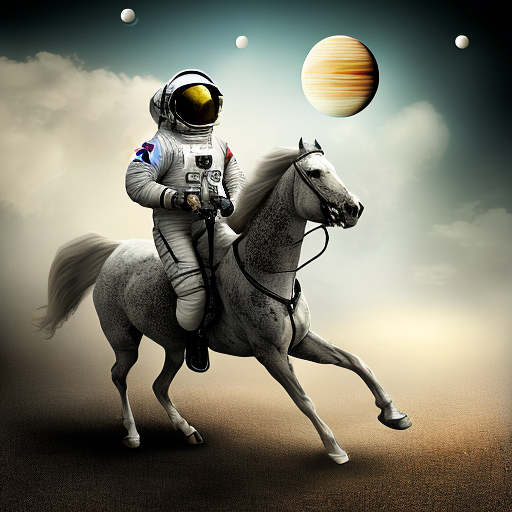

In [ ]:
# view the baseline image
baseline_res['images'][0]

## Improving the baseline with $k$ schedules

Now we sweep the Cosine Schedules with different $k$ values. Then we will check the output images and compare them to the baseline.

## `k-Sweep` runs

In [ ]:
print('Running the k-Sweep experiments...')
cos_res = run(prompt, cos_expts, guide_tfm=GuidanceTfm)

Running the k-Sweep experiments...
Using Guidance Transform: <class 'cf_guidance.transforms.GuidanceTfm'>
Running experiment [1 of 10]: Param: "k_decay", val=0.1...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 10]: Param: "k_decay", val=0.2...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [3 of 10]: Param: "k_decay", val=0.3...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [4 of 10]: Param: "k_decay", val=0.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [5 of 10]: Param: "k_decay", val=0.7...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [6 of 10]: Param: "k_decay", val=1.0...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [7 of 10]: Param: "k_decay", val=1.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [8 of 10]: Param: "k_decay", val=2...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [9 of 10]: Param: "k_decay", val=3...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [10 of 10]: Param: "k_decay", val=5...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


## `Inverse k-Sweep` runs

In [ ]:
print('Running the Inverse-k-Sweep experiments...')
inv_cos_res = run(prompt, inv_cos_expts, guide_tfm=GuidanceTfm)

Running the Inverse-k-Sweep experiments...
Using Guidance Transform: <class 'cf_guidance.transforms.GuidanceTfm'>
Running experiment [1 of 10]: Param: "k_decay", val=0.1...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 10]: Param: "k_decay", val=0.2...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [3 of 10]: Param: "k_decay", val=0.3...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [4 of 10]: Param: "k_decay", val=0.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [5 of 10]: Param: "k_decay", val=0.7...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [6 of 10]: Param: "k_decay", val=1.0...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [7 of 10]: Param: "k_decay", val=1.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [8 of 10]: Param: "k_decay", val=2...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [9 of 10]: Param: "k_decay", val=3...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [10 of 10]: Param: "k_decay", val=5...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


# Results

## `k-Sweep` results

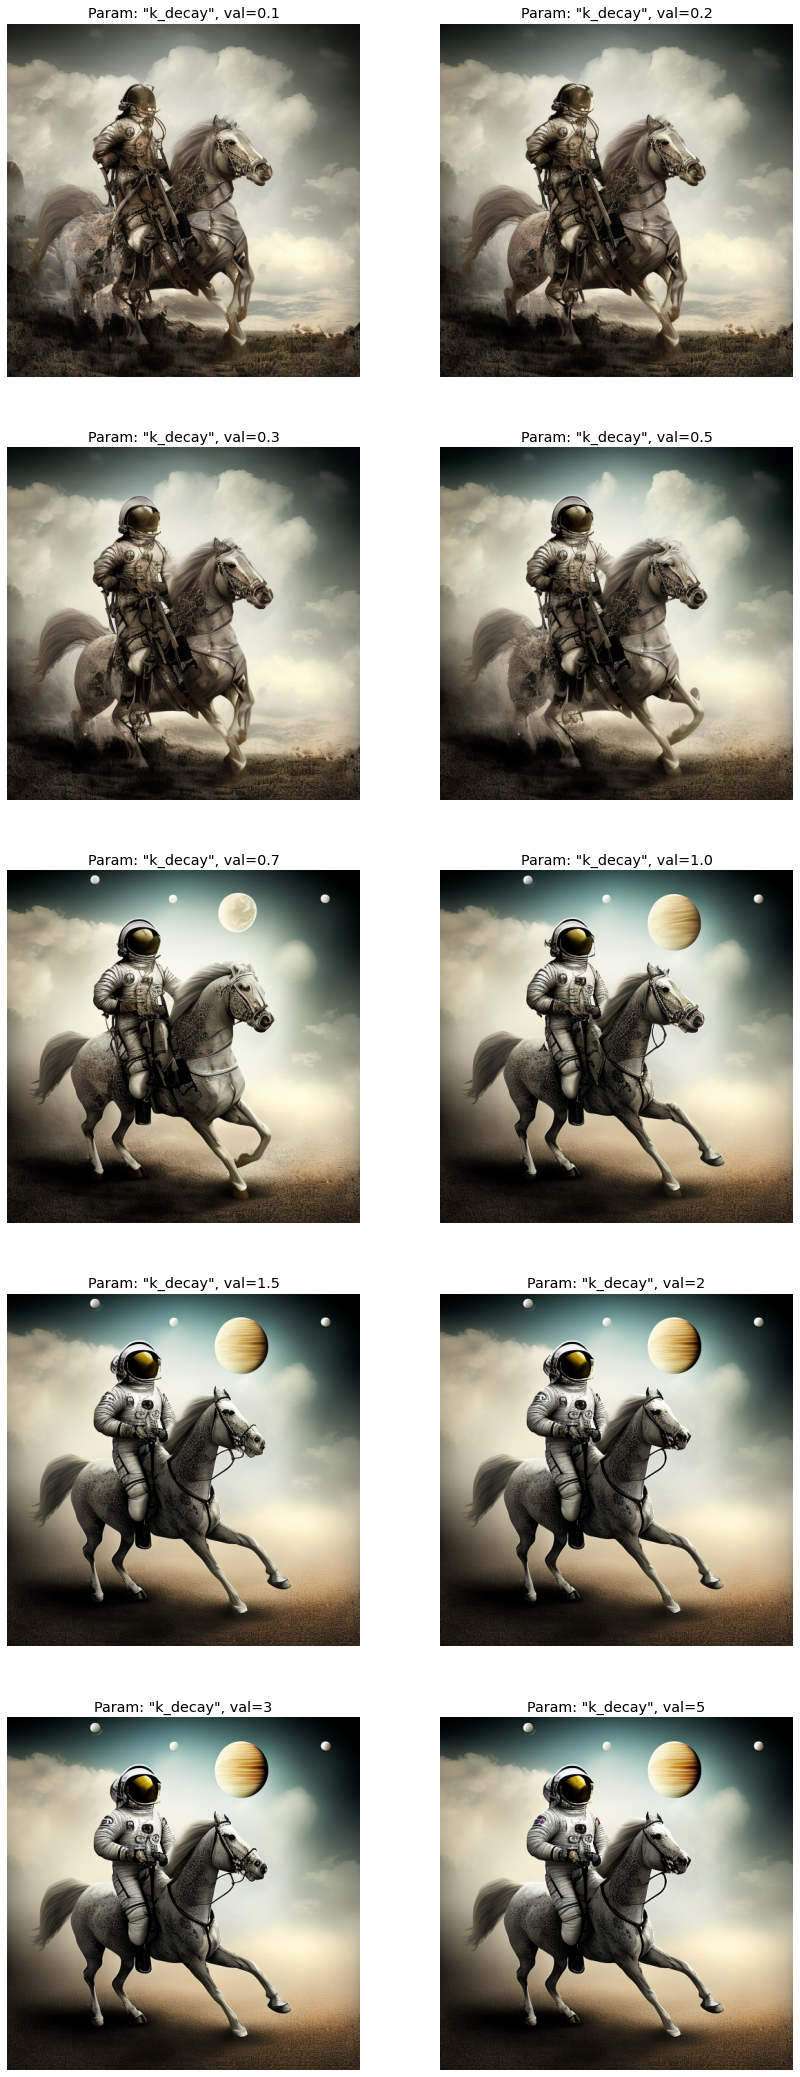

In [ ]:
#| echo: false
#| output: true
# display all images
image_grid(cos_res['images'], title=cos_res['titles'], rows=5, width=width, height=height)

## `Inverse k-Sweep` results

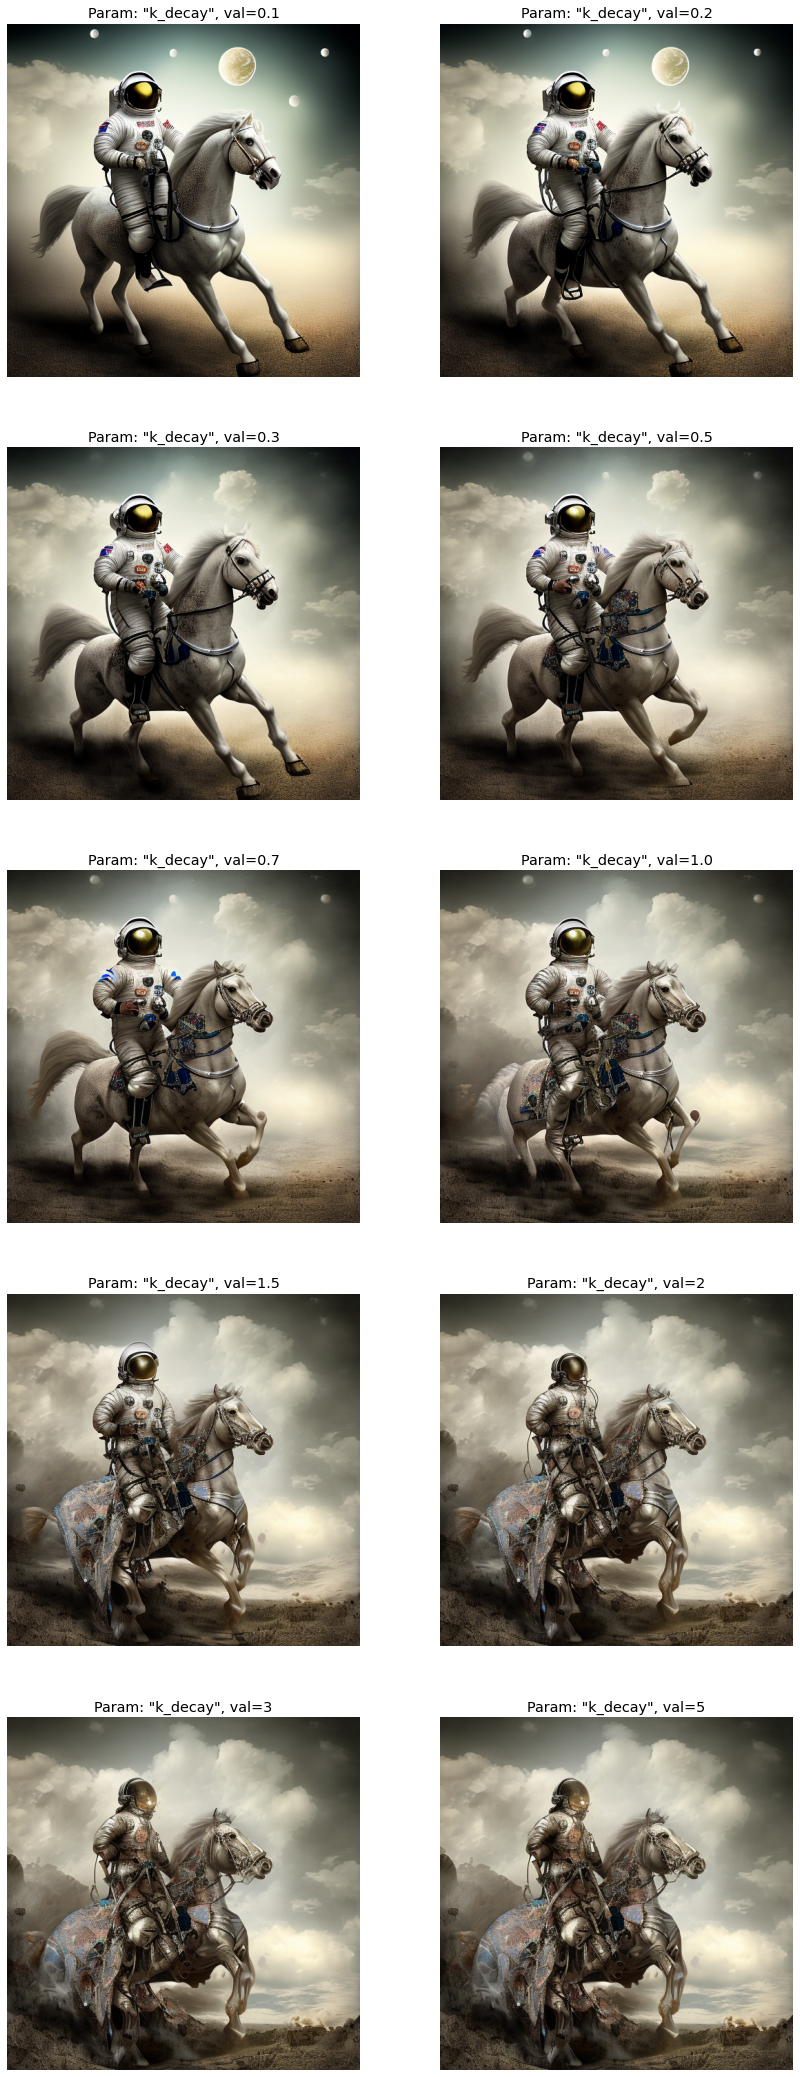

In [ ]:
#| echo: false
#| output: true
# display all images
image_grid(inv_cos_res['images'], title=inv_cos_res['titles'], rows=5, width=width, height=height)

# Analysis

A few patterns are clear.  

The $k$ schedules that take too long to reach a high guidance value $G$ suffer. This makes sense: it means we allowed the model to hallucinate for too long before guiding it towards the intended prompt.  

In the `k-Sweep` experiments we see a simiar effect with $k$ values below $1$. It seems that the guidance parameter falls off too quickly and the images became too abstract.  

There seems to be a sweet spot where $k$ increases quickly and smoothly enough. Or, where it stays high for long enough before smoothly decreasing. The pattern is clear: guidance needs to be both high enough and early enough for good image generations.  

Let's compare the baseline to some of the best $k$ generations.  

## `k-Sweep` comparison

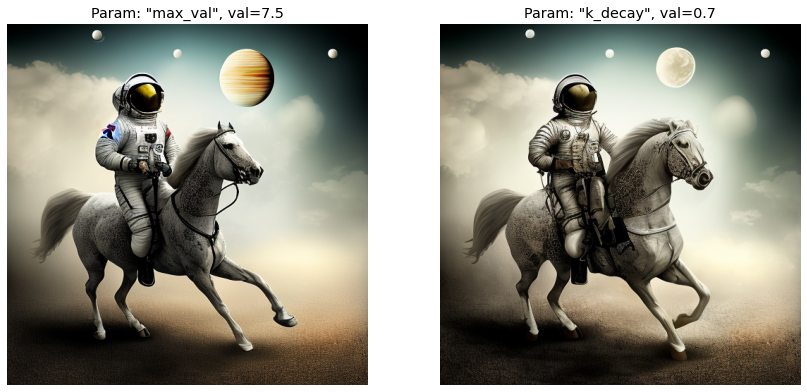

In [ ]:
#| echo: false
#| output: true
image_grid([baseline_res['images'][0], cos_res['images'][4]], 
           title=[baseline_res['titles'][0], cos_res['titles'][4]],
           rows=1, width=width, height=height)

## `Inverse k-Sweep` comparison

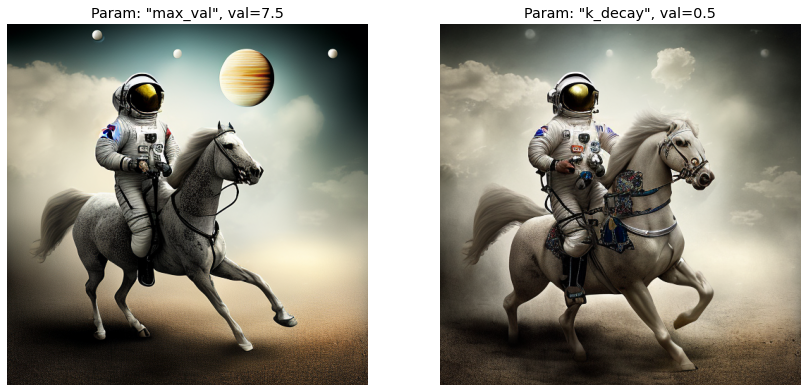

In [ ]:
#| echo: false
#| output: true
image_grid([baseline_res['images'][0], inv_cos_res['images'][3]], 
           title=[baseline_res['titles'][0], inv_cos_res['titles'][3]],
           rows=1, width=width, height=height)

In both cases, with a high and smooth value of $G$, the output image improved.  We gained more details in the background, on the horse's body, and on the astronaut's gear.  

# Conclusion

This post explored a range of `kDecay` schedules for dynamic Classifier-free Guidance. We empirically confirmed some of our intuitions about what makes for a good guidance.  

Now, thanks to Parts 1-4 in this series, we have a solid understanding of how schedules and normalizations affect the quality of Diffusion images.  

In Part 5, we will explore good good starting values for $G$ for our other kinds of normalizations. After that, we should have all the pieces of the puzzle to start putting together some powerful dynamic Classifier-free Guidances. 

In [ ]:

# #| echo: false
# #| include: false
# import torch
# import math
# import matplotlib.pyplot as plt
# num_steps = 50
# def log(t, eps = 1e-20):
#     return torch.log10(t.clamp(min = eps))
# t = torch.linspace(0, 1, num_steps)
# def alpha_cosine_log_snr(t, s = 0.008):
#     return -log((torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** -2) - 1, eps = 1e-5)
# s = alpha_cosine_log_snr(t)
# plt.plot(s)